**Andrei Dumitriu, Artificial Intelligence MS, 2020, Group 507**

This notebook explores Topic Modeling using pymc. We have implemented LDA (Latent Dirichlet Allocation) and have explored some methods and different approaches to topic modeling.

In [53]:
import pymc as pm
import numpy as np
import copy 

import os
import nltk
import wikipedia
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import seaborn as sns
# from pycontractions import Contractions
# cont = Contractions('GoogleNews-vectors-negative300.bin')

[nltk_data] Downloading package stopwords to /home/irikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/irikos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**CONTROL VARIABLES**
1. *SANITY_CHECK* 
- SET TO TRUE IF YOU WANT TO TEST ON SANITY CHECK
- SET TO FALSE IF YOU WANT TO TEST ON WIKIPEDIA PAGES

2.*CLEAR_DATA* 
- SET TO TRUE IF YOU WANT TO APPLY NLP TECHNIQUES (stemming, lemming, removing stopwords etc) on the corpus
- SET TO FALSE IF YOU WANT TO KEEP THE DOCUMENTS IN ORIGINAL FORM

In [67]:
SANITY_CHECK = False
CLEAR_DATA = True

In [68]:
# SET SANITY CHECK TO TRUE IF YOU WANT TO TEST ON SANITY CHECK
# SET SANITY CHECK TO FALSE IF YOU WANT TO TEST ON WIKIPEDIA PAGES
docs = []
new_doc = []

if (SANITY_CHECK == True):
    docs = [["aaa", "bbb", "aaa"], 
        ["bbb", "aaa", "bbb"], 
        ["aaa", "bbb", "bbb", "aaa"], 
        ["uuu", "vvv"], 
        ["uuu", "vvv", "vvv"], 
        ["uuu", "vvv", "vvv", "uuu"]]
    new_doc = ["aaa", "bbb", "aaa", "bbb", "uuu"]
else: 
    
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    # splitting the sentence into words
    page1 = wikipedia.page('Rockets')
    doc1 = tokenizer.tokenize(page1.content)[:1000] # only way to run it in this lifetime
    page2 = wikipedia.page('Exploration, Space') 
    doc2 = tokenizer.tokenize(page2.content)[:1000] # only way to run it in this lifetime
    
    docs.append(doc1)
    docs.append(doc2)
    
    new_page = wikipedia.page('Jupyter')
    new_doc = tokenizer.tokenize(new_page.content)[:1000] # only way to run it in this lifetime
    


**NLP MAGIC**

We are going to apply some NLP magic, such as stemming, lemming and removing stopwords. This will greatly help us in better identifying the underlying topic structure.

1. Split the text into words
2. Lowercase all of them
3. Remove all the stopwords
4. Apply snowball stemmer (careful, this can also decrease accuracy. For example, it will change 'meaning' into 'mean', which can have a different ...meaning
5. Apply word lemmatization
6. Enjoy, but do test it with and without clearing the data.

In [69]:
def clear_data(doc):
    # expanding words: for example, "we're" into "we are". Had an error when installing pycontractions, but should work like this
    #doc = list(cont.expand_texts([doc], precise=True))
    
    # lowercase all the words
    l_words = [word.lower() for word in doc if word.isalnum()]
    # remove stopwords
    sw = stopwords.words('english')
    l_words_sw = [word for word in l_words if word not in stopwords.words('english')]
    
#     # applying a stemmer (snowball) on each of the words thata are left
    snb = nltk.SnowballStemmer('english')
    l_words_snb = [snb.stem(word) for word in l_words_sw]
    
    # apply a lemmatizerr
    lem = WordNetLemmatizer()
    l_words_lem = [lem.lemmatize(word) for word in l_words_snb]
    return l_words_lem

In [70]:
if (CLEAR_DATA == True):
    cleared_docs = []
    for doc in docs:
        cleared_docs.append(clear_data(doc))
    docs = cleared_docs
    new_doc = clear_data(new_doc)


**Ground info**
We have created the LDA class that encompasses all the functionality we need.

The following variables are important:

K - number of topics 

M - number of documents 

V - vocabulary length

Most of the functions are explained in the comments or ar self-explanatory

In [71]:
class LDA():
    # constructor
    def __init__(self, docs, K, alpha_scalar, beta_scalar):
        
        # K is the number of topics
        self.K = K
        
        self.initialize_vocabulary(docs)
        
        self.alpha = np.ones(self.K) * alpha_scalar
        self.beta = np.ones(self.V) * beta_scalar
        
    # create the vocabulary; in index_data we have the documents with words_indexes instead of actual words
    def initialize_vocabulary(self, docs):
        self.vocabulary = self.create_vocabulary(docs)
        self.index_data = self.replace_words_with_index(docs, self.vocabulary)
        
        # M is the number of docs
        self.M = len(docs)
        
        # number of unique words
        self.V = len(self.vocabulary)
        
        
    
    def initialize_distributions(self):
        # Theta is the document distribution over the topic space
        self.theta_i = np.empty(self.M, dtype=object)
        self.theta = np.empty(self.M, dtype=object)
        for i in range(self.M):
            self.theta_i[i] = pm.Dirichlet("theta_i_%i" % i, theta = self.alpha)
            
        self.theta_i = pm.Container(self.theta_i)
        
        for i in range(self.M):
            self.theta[i] = pm.CompletedDirichlet("theta_%i" % i, self.theta_i[i])
        
        self.theta = pm.Container(self.theta)
        
        # Phi is the word distribution for the topic space
        self.phi_i = np.empty(self.K, dtype=object)
        self.phi = np.empty(self.K, dtype=object)
        
        
        for i in range(self.K):
            self.phi_i[i] = pm.Dirichlet("phi_i_%i" % i, theta = self.beta)
            
        self.phi_i = pm.Container(self.phi_i)
        
        for i in range(self.K):
            self.phi[i] = pm.CompletedDirichlet("phi_%i" % i, self.phi_i[i])
        
        self.phi = pm.Container(self.phi)
        
        # Zeeta is the word-topic mapping        
        self.zeeta = np.empty(self.M, dtype=object)
        for i in range(self.M):
            self.zeeta[i] = pm.Categorical("zeeta_%i" % i, p = self.theta[i], size = len(self.index_data[i]))
            
        self.zeeta = pm.Container(self.zeeta)
        
        
        # W is the 
        self.w = pm.Container(
            [                             # document d, word i
                pm.Categorical("w_%i_%i" % (d, i), 
                              p = pm.Lambda("phi_z_%i%i" % (d, i), 
                                           lambda z = self.zeeta[d][i], phi = self.phi : phi[z]
                                           ),
                               value = self.index_data[d][i],
                               observed = True
                              )
                for d in range(self.M) for i in range(len((self.index_data[d])))
                    
            ]
        )
        
        self.model = pm.Model([self.theta_i, self.theta, self.phi_i, self.phi, self.zeeta, self.w])
        self.mcmc = pm.MCMC(self.model)
        
    
    def get_params(self):
        theta_mean = []
        for i in range(self.M):
            theta_mean.append(self.mcmc.trace("theta_%i" % i)[:].mean(axis=0))
        
        phi_mean = []
        
        for i in range(self.K):
            phi_mean.append(self.mcmc.trace("phi_%i" % i)[:].mean(axis=0))
        
        return theta_mean, phi_mean
    
    def print_zeeta(self, size):
        for i in range(self.M):
            print("Doc_%i" % i)
            print(self.mcmc.trace("zeeta_%i" % i)[0:size])
        
    def create_vocabulary(self, data):
        index = 0
        vocabulary = {}
        for document in data:
            for word in document:
                if (word not in vocabulary.keys()):
                    vocabulary[word] = index
                    index += 1
        return vocabulary

    
    def replace_words_with_index(self, data, vocabulary):
        # damn it, python!
        index_data = copy.deepcopy(data)
        for doc_index, document in enumerate(data):
            for word_index, word in enumerate(document):
                index_data[doc_index][word_index] = vocabulary[word]

        return index_data

**Task 1**
- Build the observed variable
- Inferd the hidden topic structure
- Trace also z (this is quite hard to print in a useful manner - what did you have in mind?)

In [72]:
LDA = LDA(docs, 2, 0.5, 0.5)

In [73]:
LDA.initialize_distributions()

In [74]:
LDA.mcmc.sample(10000,2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 173.1 sec

In [75]:
(theta_mean, phi_mean) = LDA.get_params()

In [76]:
print("Theta mean:")
for item in theta_mean:
    print(item)
    
print("Phi mean:")
for item in phi_mean:
    print(item)
    
print("Zeeta")
LDA.print_zeeta(2)

Theta mean:
[[0.47180597 0.52819403]]
[[0.63603516 0.36396484]]
Phi mean:
[[5.86692741e-04 6.19775277e-03 7.35752846e-03 1.07161649e-03
  1.76303823e-05 1.88497091e-03 1.63934235e-05 9.27435343e-04
  3.86840530e-04 9.30679540e-04 5.66137525e-04 4.28478629e-03
  1.39373471e-04 9.40459737e-05 3.37390950e-04 1.09565852e-03
  1.43278356e-04 4.22479076e-03 1.42505038e-03 1.94810989e-04
  1.93341904e-04 6.12322715e-03 2.74794768e-05 2.06839383e-03
  3.96339532e-03 2.02887135e-03 6.76325629e-06 1.05883584e-04
  6.22664708e-04 2.88885013e-03 7.76083299e-04 2.29581607e-04
  4.70026879e-03 1.96053538e-03 2.29597174e-04 2.09174733e-03
  4.31353230e-04 5.08724795e-03 4.72601294e-05 1.71849511e-03
  8.33754250e-04 1.00226664e-03 2.96178730e-06 8.12316331e-04
  1.09940873e-03 5.61332054e-03 6.77176668e-05 7.90697056e-04
  3.20215119e-03 7.77322166e-05 2.88793580e-04 9.15141397e-04
  5.68412938e-04 2.29119513e-03 3.88728385e-04 8.43853916e-06
  2.20323058e-04 2.38957432e-08 1.06941622e-05 3.14484787e

**Can the topic model be used to define a topic-based similarity measure between documents?**

In order to mesaure the topic-based similarity between two documents, we have to measure the difference between their probability distributions. For this, we can use an f-divergence. Many common divergences, such as KL-Divergence, Hellinger distance and total variation distance are special cases of f-divergence, coinciding with a particular choice of f.

More info can be found here: https://en.wikipedia.org/wiki/F-divergence

I chose the Hellinger distance, as it seems to be the most popular one. https://en.wikipedia.org/wiki/Hellinger_distance

In [77]:
def plot_Hellinger_distance(LDA):
    hell_matrix = np.zeros((LDA.M, LDA.M))
    
    topic_docs = []
    for doc in range(LDA.M):
        topic_docs.append(LDA.mcmc.trace('theta_%i' % doc)[:].mean(axis=0))
        
    for i in range(LDA.M):
        for j in range(LDA.M):
            hell_matrix[i][j] = (1 / np.sqrt(2)) * np.sqrt(np.sum((np.sqrt(topic_docs[i]) - np.sqrt(topic_docs[j])) ** 2))
    
    ax = sns.heatmap(hell_matrix, annot=True, linewidths=1).set_title("Hellinger distance between documents")
    
    print(hell_matrix)

[[0.         0.11723156]
 [0.11723156 0.        ]]


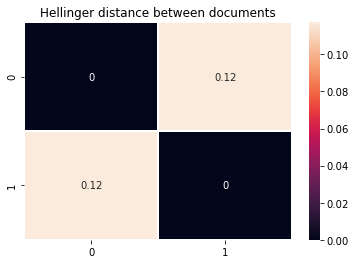

In [78]:
plot_Hellinger_distance(LDA)

**What about new documents? How can topics be assigned to it?**

The easiest way to add new documents and assing topics to add the new document to the document
list and run inference on them.


In [79]:
docs.append(new_doc)
LDA.initialize_vocabulary(docs)
LDA.mcmc.sample(2000, 1000)

 [-----------------100%-----------------] 2000 of 2000 complete in 63.1 sec

**Conclusions**

Works well on sanity check and on the examples in the course.

As for the text from wikipedia, seeing that it takes too much time to run, I only took the first 1000 words of each wikipedia page content. The results in similarity seem legit, but it is impossible to draw a real conclusion. For this, extensive testing should be done on multiple pages with more content on each.

As for text pre-processing, although it can help, it is important to pay careful attention to the text before and after it was preprocessed. Minimal preprocessing is probably the safe way to go (removing stopwords, pnctuation etc), but stemming and lemmatizing should be done carefully. 